# 人工智能纳米学位

## 语音用户界面

## 项目：通过神经网络进行语音识别

---

 在此 notebook 中，我们已经为你提供一些模板代码，要成功完成此项目，你需要实现其他功能；除此之外，不需要修改所提供的代码。标题中以**实现**开头的部分表明你必须在下面的代码块中提供其他功能。请务必仔细阅读说明！

> **注意：**完成所有代码实现后，最后需要将 iPython Notebook 导出为 HTML 文档。在将 notebook 导出为 HTML 前，请运行所有代码单元格，以便审阅专家能够查看最终实现和输出结果。然后**导出 notebook**，方法是：使用顶部的菜单并依次转到**文件 -> 下载为 -> HTML (.html)**。提交内容应该同时包含此 notebook 和完成的文档。

除了实现代码之外，还需要回答与项目和代码实现相关的问题。标题以**问题 X** 开头的每个部分表示你需要回答问题。请仔细阅读每个问题，并在**答案：**下方的文本框中提供完整的答案。我们将根据每个问题的答案以及实现代码评估你提交的项目。

>**注意：**可以通过 **Shift + Enter** 键盘快捷键执行代码和标记单元格，并且可以通过双击单元格进入编辑模式，编辑标记单元格。

审阅标准还包含可选“出色建议”，用于在满足最低要求的基础上改进项目。如果你决定落实这些“出色建议”，则应该在此 Jupyter notebook 中添加代码。

---

## 简介  

在此 notebook 中，你将构建一个用在端到端自动语音识别 (ASR) 管道中的深度神经网络！你完成的管道将接受原始音频作为输入，并返回所朗读内容的预测转录。下图总结了完整的管道。

<img src="images/pipeline.png">

- **第 1 步**是一个预处理步骤，将原始音频转换为两个特征表示之一，这种特征表示常用于 ASR。
- **第 2 步**是一个声学模型，它接受音频特征作为输入并返回所有潜在转录的概率分布。了解了声学建模经常用到的基本神经网络类型后，你将自己调查研究并设计你自己的声学模型！
- **第 3 步**：在管道中通过声学模型的输出返回一个预测转录。  

可以根据以下链接浏览此 notebook：
- [数据](#thedata)
- [**第 1 步**](#step1)：语音识别的声学特征
- [**第 2 步**](#step2)：声学建模的深度神经网络
    - [模型 0](#model0)：RNN
    - [模型 1](#model1)：RNN + TimeDistributed 密集层
    - [模型 2](#model2)：CNN + RNN + TimeDistributed 密集层
    - [模型 3](#model3)：深度 RNN + TimeDistributed 密集层
    - [模型 4](#model4)：双向 RNN + TimeDistributed 密集层
    - [模型 5+](#model5)
    - [比较模型](#compare)
    - [最终模型](#final)
- [**第 3 步**](#step3)：获取预测

<a id='thedata'></a>
## 数据

首先，我们研究下将用于训练和评估管道的数据集。[LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) 是一个用英语朗读的大型语料库，用于训练和评估 ASR 模型。该数据集包含 1000 小时的有声读物语音内容。在此项目中，我们将使用一个小型子集，因为更大规模的数据需要更长的训练时间。但是，完成此项目后，如果你想深入了解这方面的知识，建议使用[在线](http://www.openslr.org/12/)提供的更多数据。

在下面的代码单元格中，你将使用 `vis_train_features` 模块可视化训练样本。提供的参数 `index=0` 告诉模块提取训练集中的第一个样本（你可以更改 `index=0` 以指向其他训练样本，但是**请勿**修改单元格中的任何其他代码）。返回的变量为：
- `vis_text` - 训练样本的转录文本（标签）。
- `vis_raw_audio` - 训练样本的原始音频波形。
- `vis_mfcc_feature` - 训练样本的梅尔频率倒谱系数 (MFCC)。
- `vis_spectrogram_feature` - 训练样本的声谱图。 
- `vis_audio_path` - 训练样本的文件路径。

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

以下代码单元格会可视化所选样本的音频波形，以及对应的转录。你还可以在 notebook 中实验音频！

In [ ]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## 第 1 步：语音识别的声学特征

对于此项目，你不会使用原始音频波形作为模型输入。我们提供了一些首先会执行预处理步骤的代码，将原始音频转换为一种特征表示法，经证明这种表示法能够使 ASR 模型成功完成任务。你的声学模型将接受该特征表示法作为输入。

在此项目中，你将探索两种潜在特征表示法。_完成项目后_，如果你要深入了解可以接受原始音频输入的深度学习架构，建议阅读此[研究论文](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf)。

### 声谱图

第一种音频特征表示法是[声谱图](https://www.youtube.com/watch?v=_FatxGN3vAM)。为了完成此项目，你**不**需要深入了解声谱图是如何计算的；但是如果你好奇的话，计算声谱图的代码其实源自[此代码库](https://github.com/baidu-research/ba-dls-deepspeech)。实现代码位于代码库中的 `utils.py` 文件里。

我们提供的代码返回的声谱图是二维张量，第一个维度（_垂直维度_）表示时间，第一个维度（_水平维度_）表示频率。要提高算法收敛速度，我们还标准化了声谱图。（你可以在下面的可视化图形中快速看到这一点，可以发现均值在零左右，张量中的大多数条目假设值接近零。）

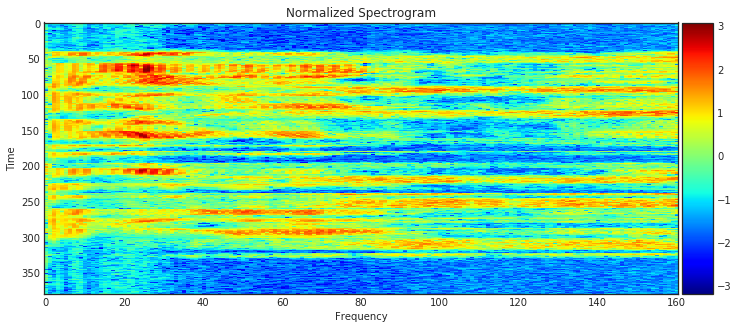

**Shape of Spectrogram** : (381, 161)

(381, 161)


In [74]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))
print(vis_spectrogram_feature.shape)

### 梅尔频率倒谱系数 (MFCC)

第二种音频特征表示法是 [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)。你**不**需要深入了解 MFCC 的计算方式，但是如果你想了解更多信息，建议阅读 `python_speech_features` Python 软件包的[文档](https://github.com/jameslyons/python_speech_features)。和声谱图特征一样，提供的代码标准化了 MFCC。

MFCC 特征的主要原理和声谱图特征一样：在每个时间窗口，MFCC 特征都会生成一个特征向量，表示该窗口中的声音特性。注意，MFCC 特征的维度比声谱图特征的低了很多，有助于声学模型避免过拟合训练数据。

In [ ]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

在构建管道时，你将能够选择使用声谱图还是 MFCC 特征。如果你要查看利用 MFCC 和/或声谱图的不同实现，请访问以下链接：
- 此[代码库](https://github.com/baidu-research/ba-dls-deepspeech)使用声谱图。
- 此[代码库](https://github.com/mozilla/DeepSpeech)使用 MFCC。
- 此[代码库](https://github.com/buriburisuri/speech-to-text-wavenet)也使用 MFCC。
- 此[代码库](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py)用原始音频、声谱图和 MFCC 作为特征进行实验。

<a id='step2'></a>
## 第 2 步：进行声学建模的深度神经网络

在此部分，你将尝试用各种神经网络架构进行声学建模。 

首先，你将训练五个相对简单的架构。我们为你提供了**模型 0**。你需要编写代码来实现**模型 1**、**2**、**3** 和 **4**。如果你想进一步实验，可以在**模型 5+** 标题下方创建和训练更多模型。

所有模型都将在 `sample_models.py` 文件中指定。导入 `sample_models` 模块后，你将在 notebook 中训练你的架构。

实验了五个简单架构后，你将有机会比较它们的性能。你将根据你的发现，构建一个旨在比所有其他模型性能都要强的深度架构。

为了方便你，我们设计了 notebook，使你能够在不同的情形下指定和训练每个模型。即，假设在训练**模型 1** 之后，你决定休息一下。那么在训练**模型 2** 之前，你不需要重新执行 notebook 中所有之前的代码单元格。在转到**模型 2** 对应的代码单元格之前，只需重新执行下面的代码单元格，标记为 **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**。

In [ ]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

<a id='model0'></a>
### 模型 0：RNN

因为 RNN 在序列数据建模方面的效果不错，因此你将使用的第一个声学模型是 RNN。如下图所示，我们提供的 RNN 将用音频特征的时间序列作为输入。

<img src="images/simple_rnn.png" width="50%">

在每个时间步，说话者会发出 28 个潜在字符中的某个字符，包括英语字母表中的 26 个字母，以及空格 (" ") 和撇号 (')。

RNN 在每个时间步的输出是一个概率向量，有 29 个条目，第 $i$- 个条目表示在时间序列中发出第 $i$ 个字符的概率。（额外的第 29 个字符是一个“空”字符，用于填充批次中长度不均匀的训练样本。）如果你要了解字符是如何映射到概率向量中的索引的，请参阅代码库中的 `char_map.py` 文件。下图是 RNN 的等效展开模式，更详细地显示了输出层。

<img src="images/simple_rnn_unrolled.png" width="60%">

我们已经在 Keras 中为你指定了模型。要导入该模型，你只需运行以下代码单元格。

In [ ]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

正如在课程中所讲解的，你将使用 [CTC 损失](http://www.cs.toronto.edu/~graves/icml_2006.pdf)条件训练声学模型。Keras 中的自定义损失函数比较复杂，因此我们已经为你实现了 CTC 损失函数，使你能够专注于尽量尝试更多的深度学习架构 :)。如果你想了解实现细节，请参阅代码库中的 `train_utils.py` 文件中的 `add_ctc_loss` 函数。

要训练架构，你将在 `train_utils` 模块中使用 `train_model` 函数；已经在上述某个代码单元格中导入该函数。`train_model` 函数**必须**传入三个参数：
- `input_to_softmax` - 一个 Keras 模型实例。
- `pickle_path` - 将保存损失记录的 pickle 文件的名称。
- `save_model_path` - 将保存模型的 HDF5 文件的名称。

如果我们已经提供 `input_to_softmax`、`pickle_path`  和 `save_model_path` 的值，请**不要**修改这些值。

有几个**可选**参数使你能够更好地控制训练流程。你可以为这些参数提供你自己的值，但是并非必须这么做。
- `minibatch_size` - 训练模型时生成的迷你批次的大小（默认为 `20`）。
- `spectrogram` - 布尔值，表示是使用声谱图 (`True`) 还是 MFCC (`False`) 特征训练模型（默认为：`True`）。
- `mfcc_dim` - 生成 MFCC 特征时使用的特征维度大小（默认为：`13`）。
- `optimizer` - 训练模型所使用的 Keras 优化器（默认为：`SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`)。 
- `epochs` - 训练模型所使用的周期次数（默认为：`20`）。如果你选择修改此参数，确保*至少为* 20。
- `verbose` - 控制 `model.fit_generator` 方法中的训练输出的详细程度（默认为：`1`）。
- `sort_by_duration` - 布尔值，表示是否在第一个周期开始前按照时长对训练集和测试集进行排序（升序）（默认为：`False`）。

`train_model` 函数默认使用声谱图特征；如果你决定使用这些特征，注意 `simple_rnn_model` 中的声学模型应该设置 `input_dim=161`。否则，如果你选择使用 MFCC 特征，声学模型应该设置 `input_dim=13`。

在提供的 RNN 中，我们选择使用 `GRU` 单元。如果你想尝试 `LSTM` 或 `SimpleRNN` 单元，可以在此 Notebook 中尝试。你可以在 `simple_rnn_model` 中将 `GRU` 单元更改为 `SimpleRNN` 单元，你可能会发现损失函数很快变得未定义  (`nan`) - 强烈建议你自己检查这一点！这是由[梯度激增问题](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)导致的。我们已经在优化器中实现了[梯度裁剪](https://arxiv.org/pdf/1211.5063.pdf)方法，帮助你避免此问题。

__重要注意事项：__如果你发现在以下任何模型中，你的梯度激增了，你可以尝试梯度裁剪（优化器中的 `clipnorm` 参数）或将任何 `SimpleRNN` 单元格更改为 `LSTM` 或 `GRU` 单元格。你还可以尝试重启核，以重启训练流程。

In [57]:
import pickle
import matplotlib.pyplot as plt

titles = ['Model 0: RNN', 
          'Model 1: RNN + TimeDistributed Dense', 
          'Model 2: CNN + RNN + TimeDistributed Dense',
          'Model 3: Deeper RNN + TimeDistributed Dense',
          'Model 4: Bidirectional RNN + TimeDistributed Dense',
          'Model 5: Conv1D + Dropout + 2*GRU + TimeDistributed Dense']

def plot_training_scores(title, model_file, show=True):
    with open(model_file,'rb') as file:
        history = pickle.load(file)
#         for x in history['loss']:
#             print(f'{x} {type(x)}')
        # Plot training & validation loss values
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title(title)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train Loss', 'Test Loss'])
        if show:
            plt.show()

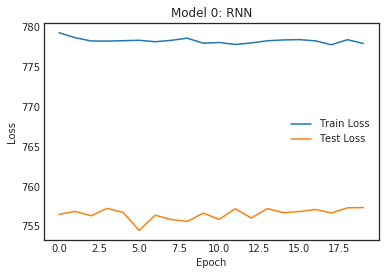

In [58]:
plot_training_scores(titles[0], 'results/model_0.pickle')

<a id='model1'></a>
### （实现）模型 1：RNN + TimeDistributed 密集层

请参阅关于 [TimeDistributed](https://keras.io/layers/wrappers/) 封装器和 [BatchNormalization](https://keras.io/layers/normalization/) 层级的 Keras 文档。对于下个架构，你将向递归层添加[批次标准化](https://arxiv.org/pdf/1510.01378.pdf)方法，以缩短训练时间。 `TimeDistributed` 层级将用于查找数据集中的更复杂模式。该架构的合拢快照如下图所示。

<img src="images/rnn_model.png" width="60%">

下图是一个等效的 RNN 展开图，更详细地显示了 (`TimeDistrbuted`) 密集层和输出层。 

<img src="images/rnn_model_unrolled.png" width="60%">

请自己研究并完成 `sample_models.py` 文件中的 `rnn_model` 函数。该函数应该指定一个满足以下要求的架构：
- 该神经网络的第一层应该是一个 RNN（`SimpleRNN`、`LSTM` 或 `GRU`），输入为音频特征时间序列。我们已经为你添加 `GRU` 单元，但是你可以将 `GRU` 更改为 `SimpleRNN` 或 `LSTM`！
- 虽然 `simple_rnn_model` 中的架构将 RNN 输出当做模型的最后层级，你将使用 RNN 的输出作为隐藏层。请使用 `TimeDistributed` 向 RNN 输出中的每个时间步应用一个 `Dense` 层级。确保每个 `Dense` 层级具有 `output_dim` 单元。

请使用以下代码单元格将模型加载到 `model_1` 变量中。`input_dim` 的值应该与所选音频特征匹配，你可以更改 `units` 和 `activation` 的值，以调整递归层的行为。

In [ ]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

请执行以下代码单元格，以训练你在 `input_to_softmax` 中指定的神经网络。模型训练完毕后，[保存](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)在 HDF5 文件 `model_1.h5` 中。损失记录[保存](https://wiki.python.org/moin/UsingPickle)在 `model_1.pickle` 中。在调用 `train_model` 函数时，你可以调整任何可选参数，但是并非必须这么做。

In [ ]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features
# Epoch 20/20
# 101/101 [==============================] - 100s 995ms/step - loss: 125.3293 - val_loss: 141.6375

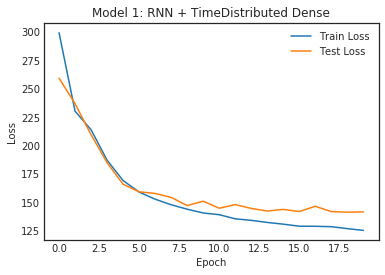

In [59]:
plot_training_scores(titles[1], 'results/model_1.pickle')

<a id='model2'></a>
### （实现）模型 2：CNN + RNN + TimeDistributed 密集层

`cnn_rnn_model` 中的架构通过引入[一维卷积层](https://keras.io/layers/convolutional/#conv1d)，增加了一层复杂性。 

<img src="images/cnn_rnn_model.png" width="100%">

此层级包含很多在调用 `cnn_rnn_model` 模块时可以调整（可选操作）的参数。我们提供了示例起始参数，如果你选择使用声谱图音频特征，可能会发现这些参数很有用。 

如果你想使用 MFCC 特征，则需要调整这些参数。注意，对于 `conv_border_mode` 参数来说，当前架构只支持 `'same'` 或 `'valid'` 值。

在调整参数时，请注意避免选择导致卷积层过小的设置。如果 CNN 层级的时序长度比转录文本标签的长度短，代码将抛出错误。

在调整下面的代码单元格之前，你必须修改 `sample_models.py` 中的 `cnn_rnn_model` 函数。请向递归层添加批次标准化方法，并提供和之前一样的 `TimeDistributed` 层级。

In [ ]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

请执行以下代码单元格，以训练你在 `input_to_softmax` 中指定的神经网络。模型训练完毕后，[保存](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)在 HDF5 文件 `model_2.h5` 中。损失记录[保存](https://wiki.python.org/moin/UsingPickle)在 `model_2.pickle` 中。在调用 `train_model` 函数时，你可以调整任何可选参数，但是并非必须这么做。

In [ ]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features
# Epoch 20/20
# 101/101 [==============================] - 25s 252ms/step - loss: 80.6195 - val_loss: 146.7799

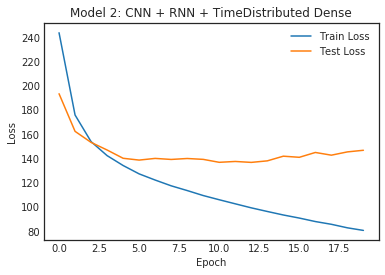

In [61]:
plot_training_scores(titles[2], 'results/model_2.pickle')

# overfitting
# 1. early stopping
# A good approach to stop overfitting with neural nets is early stopping against a validation dataset.
# Keras supports this here:
# https://keras.io/callbacks/#earlystopping
# 2. dropout

<a id='model3'></a>
### （实现）模型 3：深度 RNN + TimeDistributed 密集层

请查看 `rnn_model` 中的代码，该模型使用了一个 Recurrent 层。现在，请在 `deep_rnn_model` 中指定一个利用多个 (`recur_layers`) Recurrent 层的架构。下图显示了如果 `recur_layers=2` 应该返回的架构。在此图中，第一个递归层的输出序列用作下个递归层的输入。

<img src="images/deep_rnn_model.png" width="80%">

你可以将提供的 `units` 值更改为你认为效果最佳的值。你可以更改 `recur_layers` 的值，只要最终值大于 1 即可。（为了快速检查你是否在 `deep_rnn_model` 中正确实现了额外功能，如果 `recur_layers=1`，确保你在此文件中指定的架构与 `rnn_model` 完全一样。）

In [ ]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

请执行以下代码单元格，以训练你在 `input_to_softmax` 中指定的神经网络。模型训练完毕后，[保存](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)在 HDF5 文件 `model_3.h5` 中。损失记录[保存](https://wiki.python.org/moin/UsingPickle)在 `model_3.pickle` 中。在调用 `train_model` 函数时，你可以调整任何可选参数，但是并非必须这么做。

In [ ]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features
# Epoch 20/20
# 101/101 [==============================] - 196s 2s/step - loss: 107.3377 - val_loss: 132.3426

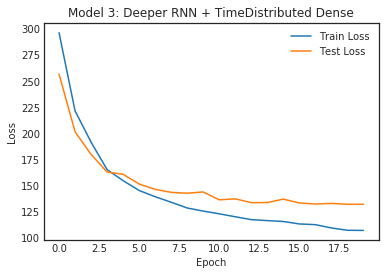

In [62]:
plot_training_scores(titles[3], 'results/model_3.pickle')

<a id='model4'></a>
### （实现）模型 4：双向 RNN + TimeDistributed 密集层

阅读[双向](https://keras.io/layers/wrappers/)封装器的 Keras 文档。对于下个架构，你将指定一个在 (`TimeDistributed`) 密集层之前使用单个双向 RNN 层级的架构。[此论文](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf)详细解释了双向 RNN 的优势。
> 传统 RNN 的一个缺点是它们只能利用之前的语境。在语音识别中，整个话语都会一次性转录，因此也需要利用后续语境。双向 RNN (BRNN) 可以满足此需求，它使用两个单独的隐藏层朝着两个方向处理数据，然后，两个隐藏层的结果都传入相同的输出层。

<img src="images/bidirectional_rnn_model.png" width="80%">

在运行以下代码单元格之前，你必须完成 `sample_models.py` 中的 `bidirectional_rnn_model` 函数。你可以使用 `SimpleRNN`、`LSTM` 或 `GRU` 单元。在指定 `Bidirectional` 封装器时，请使用 `merge_mode='concat'`。

In [ ]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

请执行以下代码单元格，以训练你在 `input_to_softmax` 中指定的神经网络。模型训练完毕后，[保存](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)在 HDF5 文件 `model_4.h5` 中。损失记录[保存](https://wiki.python.org/moin/UsingPickle)在 `model_4.pickle` 中。在调用 `train_model` 函数时，你可以调整任何可选参数，但是并非必须这么做。

In [ ]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features
# Epoch 20/20
# 101/101 [==============================] - 192s 2s/step - loss: 111.9985 - val_loss: 143.4751

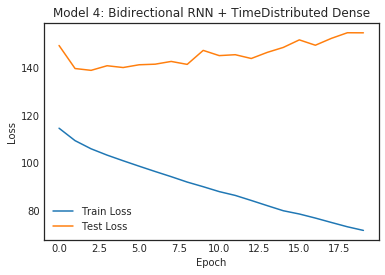

In [47]:
plot_training_scores(titles[4], 'results/model_4.pickle')

<a id='model5'></a>
### （可选实现）模型 5+

如果你想尝试上述架构之外的其他架构，请使用以下代码单元格。请继续按照相同的格式保存模型；对于第 $i$ 个示例模型，请将损失保存到 **`model_i.pickle`**，将训练的模型保存到 **`model_i.h5`**。

In [ ]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

<a id='compare'></a>
### 比较模型

执行以下代码单元格，评估草稿深度学习模型的性能。我们绘制了每个模型的训练和验证损失图。

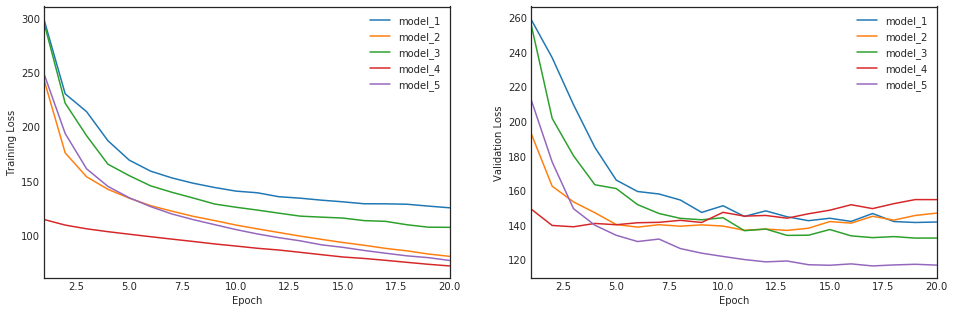

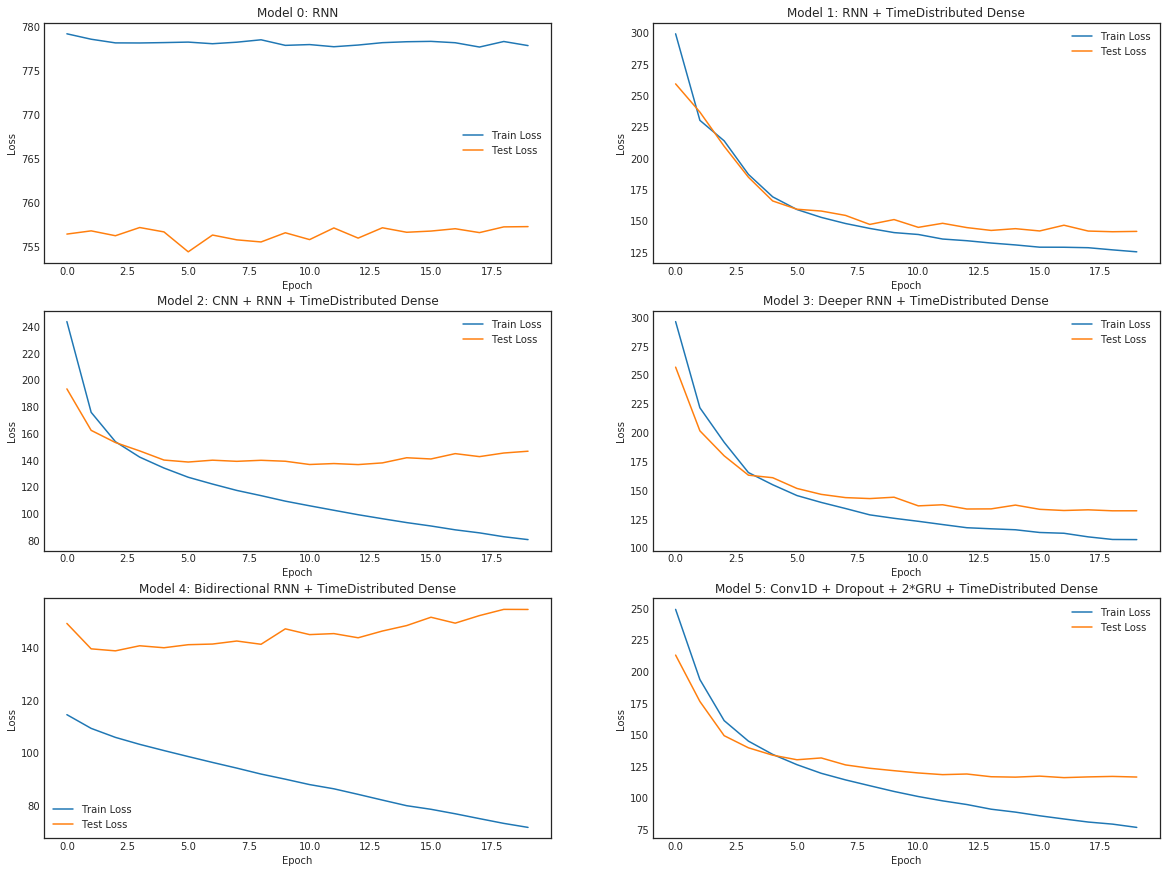

In [64]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(1, len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(1, len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

plt.show()
fig = plt.figure(figsize=(20,15))
for i in range(len(titles)):
    ax = fig.add_subplot(3, 2, i+1)
    plot_training_scores(titles[i], f'results/model_{i}.pickle', show=False)

plt.show()

__问题 1：__ 利用上图分析每个实验架构的性能。哪个架构的性能最好？请解释下你为何认为某些模型的性能比其他模型好。

__答案：__

By ploting the loss and compare the predict result, I have the following ovservation:

Model 0: RNN
    Perfomaed poorly. Maybe because the memory of simple rnn cannot capture the sequencal knowledge of the input. Or maybe because the rnn layer should not used this way, the sequencal information was lost. Enroll the deep learning course to learn more about DNN and keras.
    
Model 1: RNN + TimeDistributed Dense
    Adding time distributed dense layer make the performance looks better, but if you check the predicted results, it still perform poorly. The predicted text dosen't make scense.
    
Model 2: CNN + RNN + TimeDistributed Dense:
    Adding cnn layer is really boosting the performance, the predicted text start to make some scense. 
    The network converges very fast at 3 , 4 epech.
    Becuse CNN layer can extract more features from input data.
    But the valid loss descrease after 5 epoch, that is the sign of overfitting. To avoid overfitting we can training ealier or add dropout layer. 
    Eventhought the performance of loss is a big boosting, but if you check the predicted text, it seems one RNN layer cannot capture engough knowledg.
    
Model 3: Deeper RNN + TimeDistributed Dense
    The predicte results of model 3 looks better than model 2, but training process converge slower than model 2.

Model 4: Bidirectional RNN + TimeDistributed Dense
    The performance is close to model 2, converge very fast, but suffer from overfitting.
    
So the there is no wining model. Model 2 extract more features from input, model 3 can restore more knowlege, model 4 can restore context information. Combine that together we can make a better model.

<a id='final'></a>
### （实现）最终模型

你已经尝试了多个实例模型，请运用所学的知识构建你自己的架构！虽然最终声学模型不一定要与上面探索的任何架构完全一样，但是你可以仅将上面探索的层级添加到更深的架构中。**并非**必须包含在 notebook 中没有探索过的新层级类型。

但是，如果你想了解如何添加更多种类的层级，请参阅以下内容，了解如何向模型中添加其他可选扩展功能：

- 如果你发现模型过拟合训练数据集，请考虑添加**丢弃**！要向[递归层](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/)中添加丢弃，请注意 `dropout_W` 和 `dropout_U` 参数。此[论文](http://arxiv.org/abs/1512.05287)也提供了一些有趣的理论知识。
- 如果你选择在模型中添加卷积层，使用**扩张卷积**可能会获得更好的结果。如果选择使用扩张卷积，确保能够在 `model.output_length` lambda 函数中准确计算声学模型的输出长度。你可以在 Google 的 [WaveNet 论文](https://arxiv.org/abs/1609.03499)中详细了解扩张卷积。要查看利用扩张卷积的语音转文字系统示例，请参阅此 GitHub [代码库](https://github.com/buriburisuri/speech-to-text-wavenet)。你可以[在 Keras](https://keras.io/layers/convolutional/) 中使用扩张卷积，但是在指定卷积层时需要特别注意 `padding` 参数。
- 如果你的模型利用了卷积层，为何不添加**最大池化**层呢？请参阅[此论文](https://arxiv.org/pdf/1701.02720.pdf)，了解在声学模型中利用最大池化层的示例架构。
- 到目前为止，你尝试了单个双向 RNN 层级。可以考虑堆叠双向层级，生成[深度双向 RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)！

你在此代码库中指定的所有模型应该定义属性 `output_length`。此属性是一个 lambda 函数，可以将输入声学特征的（时序）长度映射到输出 softmax 层。此函数可以用于计算 CTC 损失；要查看这一点，请查看 `train_utils.py` 中的 `add_ctc_loss` 函数。要查看在代码中的什么位置定义模型的 `output_length` 属性，请查看 `sample_models.py` 文件。你将在大多数模型中注意到以下这行代码：

In [ ]:
model.output_length = lambda x: x

包含卷积层的声学模型 (`cnn_rnn_model`) 具有稍微不同的代码行：

In [ ]:
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)

对于完全使用递归层的模型，该 lambda 函数是一个恒等函数，因为递归层不会修改输入张量的（时序）长度。但是，卷积层更复杂，需要使用特殊函数（`sample_models.py` 中的 `cnn_output_length`） 确定输出的时序长度。

在运行以下代码单元格之前，你需要将 `output_length` 属性添加到最终模型中。你可以使用 `cnn_output_length` 函数，如果它适合你的模型的话。

In [66]:
# specify the model
model_5 = final_model(input_dim=161, units=200, filters=200, kernel_size=11,
                        output_dim=29, drop_rate=0.25, conv_stride=2,
                        conv_border_mode='valid', recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
batch_norm_rnn0 (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
__________

请执行以下代码单元格，以训练你在 `input_to_softmax` 中指定的神经网络。模型训练完毕后，[保存](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)在 HDF5 文件 `model_end.h5` 中。损失记录[保存](https://wiki.python.org/moin/UsingPickle)在 `model_end.pickle` 中。在调用 `train_model` 函数时，你可以调整任何可选参数，但是并非必须这么做。

In [ ]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
100/101 [============================>.] - ETA: 0s - loss: 249.9237

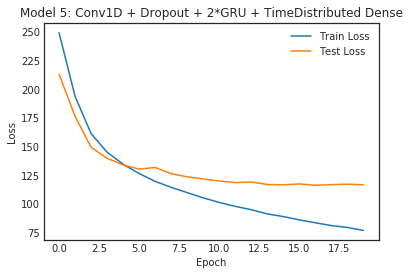

In [70]:
plot_training_scores(titles[5], 'results/model_5.pickle')

__问题 2：__描述你的最终模型架构和每一步的推理过程。  

__答案：__

1. CNN layer can help extract more features from input. 
2. But will extract feature not really exist in the really pattern , that make the whole network suffur from overfitting. So I add a dropout layer to prevent overfitting. 
3. I add 2 layer of RNN to restore more knowlege of the input data.
4. Then I add time distributed layer to orgnize the output.



<a id='step3'></a>
## 第 3 步：获取预测

我们为你编写了一个函数，用于解码声学模型的预测。要使用该函数，请执行以下代码单元格。

In [92]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + transcr)
    print('-'*80)
    #print('Predicted integers:\n[%s]' % ','.join([str(i) for i in pred_ints]))
    print('Predicted transcription:\n[%s]'% ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

请通过以下代码单元格获取最终模型对训练数据集中第一个样本预测的转录结果。

In [93]:
model_5 = final_model(input_dim=161, units=200, filters=200, kernel_size=11,
                        output_dim=29, drop_rate=0.25, conv_stride=2,
                        conv_border_mode='valid', recur_layers=2)
get_predictions(index=0, 
                partition='train',
                input_to_softmax=model_5, 
                model_path='results/model_5.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
batch_norm_rnn0 (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
__________

In [94]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

model_5 = final_model(input_dim=161, units=200, filters=200, kernel_size=11,
                        output_dim=29, drop_rate=0.25, conv_stride=2,
                        conv_border_mode='valid', recur_layers=2)
models = [model_0, model_1, model_2, model_3, model_4, model_5]
for j in range(5):
    for i, model in enumerate(models):
        print(f'\n{titles[i]}:')
        get_predictions(index=j, 
                        partition='train',
                        input_to_softmax=model, 
                        model_path=f'results/model_{i}.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
b

--------------------------------------------------------------------------------
True transcription:
her father is a most remarkable person to say the least
--------------------------------------------------------------------------------
Predicted transcription:
[her fota as a mosrmark able persn to sey teleset]
--------------------------------------------------------------------------------

Model 5: Conv1D + Dropout + 2*GRU + TimeDistributed Dense:
--------------------------------------------------------------------------------
True transcription:
her father is a most remarkable person to say the least
--------------------------------------------------------------------------------
Predicted transcription:
[herfother is a moser markaba person to say that lyast]
--------------------------------------------------------------------------------

Model 0: RNN:
--------------------------------------------------------------------------------
True transcription:
but it is quite plain to me t

--------------------------------------------------------------------------------
True transcription:
for instance look at their behaviour in the matter of the ring
--------------------------------------------------------------------------------
Predicted transcription:
[fror tons woge ther be evevurin the materf ther wrang ]
--------------------------------------------------------------------------------

Model 4: Bidirectional RNN + TimeDistributed Dense:
--------------------------------------------------------------------------------
True transcription:
for instance look at their behaviour in the matter of the ring
--------------------------------------------------------------------------------
Predicted transcription:
[forenstense look ad theer beever in tha matr of the ring]
--------------------------------------------------------------------------------

Model 5: Conv1D + Dropout + 2*GRU + TimeDistributed Dense:
---------------------------------------------------------------------

通过下个代码单元格可视化模型对验证数据集中第一个样本的预测结果。

In [95]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=model_5, 
                model_path='results/model_5.h5')

--------------------------------------------------------------------------------
True transcription:
the bogus legislature numbered thirty six members
--------------------------------------------------------------------------------
Predicted transcription:
[the bl lis ligislatur nevers therte six memers]
--------------------------------------------------------------------------------


In [96]:
for j in range(5):
    for i, model in enumerate(models):
        print(f'\n{titles[i]}:')
        get_predictions(index=j, 
                        partition='validation',
                        input_to_softmax=model, 
                        model_path=f'results/model_{i}.h5')


Model 0: RNN:
--------------------------------------------------------------------------------
True transcription:
the bogus legislature numbered thirty six members
--------------------------------------------------------------------------------
Predicted transcription:
[      ]
--------------------------------------------------------------------------------

Model 1: RNN + TimeDistributed Dense:
--------------------------------------------------------------------------------
True transcription:
the bogus legislature numbered thirty six members
--------------------------------------------------------------------------------
Predicted transcription:
[    rer  ]
--------------------------------------------------------------------------------

Model 2: CNN + RNN + TimeDistributed Dense:
--------------------------------------------------------------------------------
True transcription:
the bogus legislature numbered thirty six members
-----------------------------------------------------

--------------------------------------------------------------------------------
True transcription:
this was a formidable array of advantages slavery was playing with loaded dice
--------------------------------------------------------------------------------
Predicted transcription:
[ r  r  ]
--------------------------------------------------------------------------------

Model 2: CNN + RNN + TimeDistributed Dense:
--------------------------------------------------------------------------------
True transcription:
this was a formidable array of advantages slavery was playing with loaded dice
--------------------------------------------------------------------------------
Predicted transcription:
[is isly forabworerof thet triningeusslatver as li wofs lotad daie]
--------------------------------------------------------------------------------

Model 3: Deeper RNN + TimeDistributed Dense:
--------------------------------------------------------------------------------
True transcripti

改善解码器结果的一种标准方式是添加语言模型。在此 notebook 中，我们不要求这么做，但是你可以将此过程当做_可选拓展练习_。

如果你想创建转录效果更好的模型，建议下载[更多数据](http://www.openslr.org/12/)并训练更大更深的模型。但是注意，模型可能需要更长的训练时间。例如，在单个 GPU 上训练这个[先进的](https://arxiv.org/pdf/1512.02595v1.pdf)模型需要 3-6 周时间！